In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import numpy as np
import json
from torch.utils.data import DataLoader
import torch



In [2]:
random_seed = 123
N = 100
K = 10
colors = ["#FF4500", "#228B22", "#FFA500", "#32CD32"]

torch.set_num_threads(32)

In [3]:
# Generate drifted dataset

X, Y = make_blobs(n_samples=N*4, n_features=2, centers=[[-2,-2],[3,3],[0,-1],[4,5]], cluster_std=2, random_state=random_seed)

source_idx0 = Y == 0
source_idx1 = Y == 1
target_idx0 = Y == 2
target_idx1 = Y == 3

X_source = X[source_idx0 | source_idx1]
X_target = X[target_idx0 | target_idx1]

y_source = Y[source_idx0 | source_idx1]
y_target = Y[target_idx0 | target_idx1] - 2

print(X_source.shape, X_target.shape, y_source.shape, y_target.shape)

(200, 2) (200, 2) (200,) (200,)


In [4]:
# Select target data to label

X_target_labeled, X_target_unlabeled, y_target_labeled, y_target_unlabeled = train_test_split(X_target, y_target, train_size=K/N, random_state=0)

print(X_target_labeled.shape, X_target_unlabeled.shape, y_target_labeled.shape, y_target_unlabeled.shape)

(20, 2) (180, 2) (20,) (180,)


In [6]:
# Dump data

with open("toy_data/cluster.npy", "wb") as f:
    np.save(f, X_source)
    np.save(f, y_source)
    np.save(f, X_target_labeled)
    np.save(f, y_target_labeled)
    np.save(f, X_target_unlabeled)
    np.save(f, y_target_unlabeled)


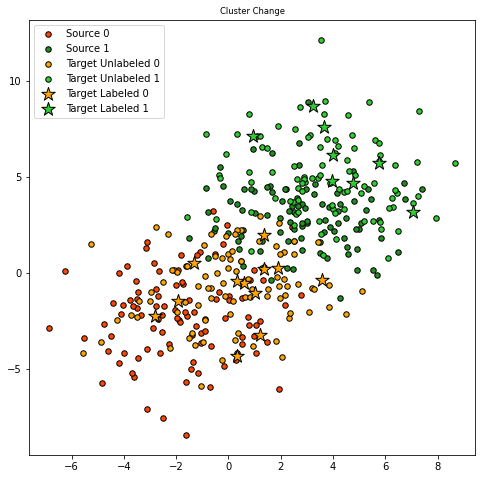

In [5]:
plt.figure(figsize=(8, 8))
plt.title("Cluster Change", fontsize="small")

s0 = plt.scatter(X_source[y_source==0][:, 0], X_source[y_source==0][:, 1], marker='o', c=colors[0], s=30, edgecolor='k')
s1 = plt.scatter(X_source[y_source==1][:, 0], X_source[y_source==1][:, 1], marker='o', c=colors[1], s=30, edgecolor='k')
s2 = plt.scatter(X_target_unlabeled[y_target_unlabeled==0][:, 0], X_target_unlabeled[y_target_unlabeled==0][:, 1], marker='o', c=colors[2], s=30, edgecolor='k')
s3 = plt.scatter(X_target_unlabeled[y_target_unlabeled==1][:, 0], X_target_unlabeled[y_target_unlabeled==1][:, 1], marker='o', c=colors[3], s=30, edgecolor='k')
s4 = plt.scatter(X_target_labeled[y_target_labeled==0][:, 0], X_target_labeled[y_target_labeled==0][:, 1], marker='*', c=colors[2], s=200, edgecolor='k')
s5 = plt.scatter(X_target_labeled[y_target_labeled==1][:, 0], X_target_labeled[y_target_labeled==1][:, 1], marker='*', c=colors[3], s=200, edgecolor='k')
plt.legend((s0, s1, s2, s3, s4, s5), ("Source 0", "Source 1", "Target Unlabeled 0", "Target Unlabeled 1", "Target Labeled 0", "Target Labeled 1"))

plt.show()

In [3]:
from toy import ToyDataset, train, load_data, predict

X_source, y_source, X_target_labeled, y_target_labeled, X_target_unlabeled, y_target_unlabeled = load_data("toy_data/cluster.npy")


In [5]:
def plot_decision_boundary(model, train_dataset, valid_dataset, test_dataset):
    # Set min and max values and give it some padding
    x_min = min(train_dataset.X[:, 0].min(), valid_dataset.X[:, 0].min(), test_dataset.X[:, 0].min()) - .5
    x_max = max(train_dataset.X[:, 0].max(), valid_dataset.X[:, 0].max(), test_dataset.X[:, 0].max()) + .5
    y_min = min(train_dataset.X[:, 1].min(), valid_dataset.X[:, 1].min(), test_dataset.X[:, 1].min()) - .5
    y_max = max(train_dataset.X[:, 1].max(), valid_dataset.X[:, 1].max(), test_dataset.X[:, 1].max()) + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # print(xx[:5], yy[:5])
    # print(xx.shape, yy.shape)
    # print(np.c_[xx.ravel(), yy.ravel()])


    # Predict the function value for the whole gid
    Z = predict(model, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.title("Cluster Decision Boundary", fontsize="small")
    # # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

    s0 = plt.scatter(train_dataset.X[train_dataset.y==0][:, 0], train_dataset.X[train_dataset.y==0][:, 1], marker='o', c=colors[0], s=30, edgecolor='k')
    s1 = plt.scatter(train_dataset.X[train_dataset.y==1][:, 0], train_dataset.X[train_dataset.y==1][:, 1], marker='o', c=colors[1], s=30, edgecolor='k')
    s2 = plt.scatter(test_dataset.X[test_dataset.y==0][:, 0], test_dataset.X[test_dataset.y==0][:, 1], marker='o', c=colors[2], s=30, edgecolor='k')
    s3 = plt.scatter(test_dataset.X[test_dataset.y==1][:, 0], test_dataset.X[test_dataset.y==1][:, 1], marker='o', c=colors[3], s=30, edgecolor='k')
    s4 = plt.scatter(valid_dataset.X[valid_dataset.y==0][:, 0], valid_dataset.X[valid_dataset.y==0][:, 1], marker='*', c=colors[2], s=200, edgecolor='k')
    s5 = plt.scatter(valid_dataset.X[valid_dataset.y==1][:, 0], valid_dataset.X[valid_dataset.y==1][:, 1], marker='*', c=colors[3], s=200, edgecolor='k')
    plt.legend((s0, s1, s2, s3, s4, s5), ("Train 0", "Train 1", "Test 0", "Test 1", "Valid 0", "Valid 1"))

    plt.show()



[Train] epoch 0, loss: 0.7797889113426208, last 100 averaged loss: 0.7797889113426208
[Train] loss: 0.7438321113586426, accuracy: 0.5333333333333333
[Valid] loss: 1.0844370126724243, accuracy: 0.3
[Test] loss: 0.9881453514099121, accuracy: 0.3333333333333333
[Train] epoch 100, loss: 0.16375519335269928, last 100 averaged loss: 0.28867471143603324
[Train] loss: 0.16269974410533905, accuracy: 0.9523809523809523
[Valid] loss: 0.5029600858688354, accuracy: 0.8
[Test] loss: 0.3718433082103729, accuracy: 0.8277777777777777
[Train] epoch 200, loss: 0.13068784773349762, last 100 averaged loss: 0.1402905385196209
[Train] loss: 0.13061217963695526, accuracy: 0.9571428571428572
[Valid] loss: 0.5618871450424194, accuracy: 0.8
[Test] loss: 0.3507660925388336, accuracy: 0.8611111111111112
[Train] epoch 300, loss: 0.12744495272636414, last 100 averaged loss: 0.12855443850159645
[Train] loss: 0.1274334192276001, accuracy: 0.9571428571428572
[Valid] loss: 0.6251723170280457, accuracy: 0.8
[Test] loss: 

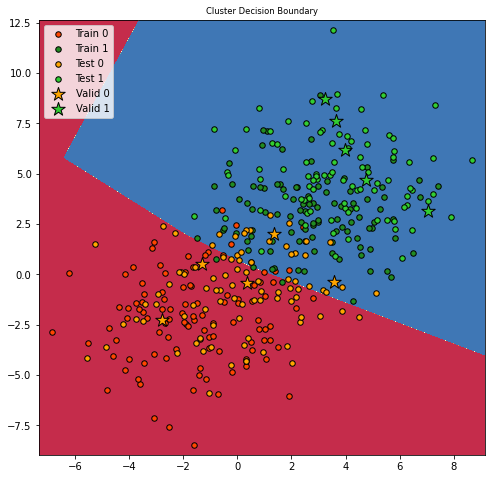

In [6]:
# Train: source + k labeled target
# Valid: k labeled target
# Test: unlabeled target

train_dataset = ToyDataset(np.concatenate((X_source, X_target_labeled[:K]), axis=0), np.concatenate((y_source, y_target_labeled[:K]), axis=0))
valid_dataset = ToyDataset(X_target_labeled[K:], y_target_labeled[K:])
test_dataset = ToyDataset(X_target_unlabeled, y_target_unlabeled)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model0 = train(train_loader, valid_loader, test_loader)
plot_decision_boundary(model0, train_dataset, valid_dataset, test_dataset)

[Train] epoch 0, loss: 1.0380820035934448, last 100 averaged loss: 1.0380820035934448
[Train] loss: 0.9881451725959778, accuracy: 0.3333333333333333
[Valid] loss: 1.0067503452301025, accuracy: 0.3
[Test] loss: 0.7345706224441528, accuracy: 0.545
[Train] epoch 100, loss: 0.17319053411483765, last 100 averaged loss: 0.44551527112722394
[Train] loss: 0.1702212393283844, accuracy: 0.9055555555555556
[Valid] loss: 0.11796333640813828, accuracy: 0.95
[Test] loss: 0.22280418872833252, accuracy: 0.915
[Train] epoch 200, loss: 0.08446266502141953, last 100 averaged loss: 0.10234704248607158
[Train] loss: 0.08443574607372284, accuracy: 0.9611111111111111
[Valid] loss: 0.028525460511446, accuracy: 1.0
[Test] loss: 0.3843068778514862, accuracy: 0.855
[Train] epoch 300, loss: 0.08325805515050888, last 100 averaged loss: 0.08367728658020496
[Train] loss: 0.08325345814228058, accuracy: 0.9611111111111111
[Valid] loss: 0.025590697303414345, accuracy: 1.0
[Test] loss: 0.40755149722099304, accuracy: 0.8

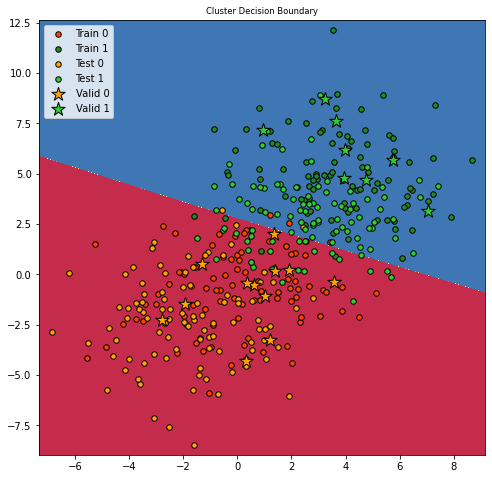

In [7]:
# Train: unlabeled target
# Valid: labeled target
# Test: source

train_dataset = ToyDataset(X_target_unlabeled, y_target_unlabeled)
valid_dataset = ToyDataset(X_target_labeled, y_target_labeled)
test_dataset = ToyDataset(X_source, y_source)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model1 = train(train_loader, valid_loader, test_loader)
plot_decision_boundary(model1, train_dataset, valid_dataset, test_dataset)

Accuracy:  0.855
[Train] epoch 0, loss: 0.7796190977096558, last 100 averaged loss: 0.7796190977096558
[Train] loss: 0.7411086559295654, accuracy: 0.5497076023391813
[Valid] loss: 1.0068905353546143, accuracy: 0.3
[Test] loss: 0.9882838726043701, accuracy: 0.3333333333333333
[Train] epoch 100, loss: 0.10325264185667038, last 100 averaged loss: 0.24265359200537204
[Train] loss: 0.10172664374113083, accuracy: 0.9707602339181286
[Valid] loss: 0.4654974043369293, accuracy: 0.8
[Test] loss: 0.3668648898601532, accuracy: 0.8333333333333334
[Train] epoch 200, loss: 0.034283366054296494, last 100 averaged loss: 0.05736083272844553
[Train] loss: 0.034049294888973236, accuracy: 0.9941520467836257
[Valid] loss: 0.1812915951013565, accuracy: 0.9
[Test] loss: 0.19697323441505432, accuracy: 0.9055555555555556
[Train] epoch 300, loss: 0.020812183618545532, last 100 averaged loss: 0.026228087861090897
[Train] loss: 0.02073591761291027, accuracy: 0.9941520467836257
[Valid] loss: 0.13912411034107208, ac

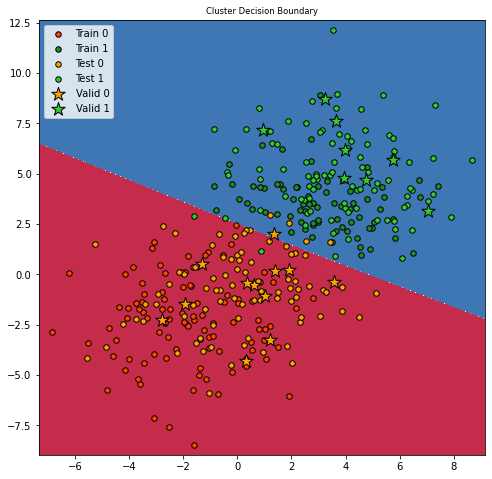

In [8]:
# Cheat: remove mislabeled source and train
# Train: correctly labeled source data by model 1
# Valid: labeled target
# Test: unlabeled target

pred = predict(model1, X_source)
correct_idx = pred == y_source.numpy()
print("Accuracy: ", np.mean(correct_idx))

train_dataset = ToyDataset(X_source[correct_idx], y_source[correct_idx])
valid_dataset = ToyDataset(X_target_labeled, y_target_labeled)
test_dataset = ToyDataset(X_target_unlabeled, y_target_unlabeled)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model2 = train(train_loader, valid_loader, test_loader)
plot_decision_boundary(model2, train_dataset, valid_dataset, test_dataset)


In [39]:
harmful0 = influences["harmful"]

In [43]:
X_target_labeled[1]

tensor([1.3736, 0.1715])

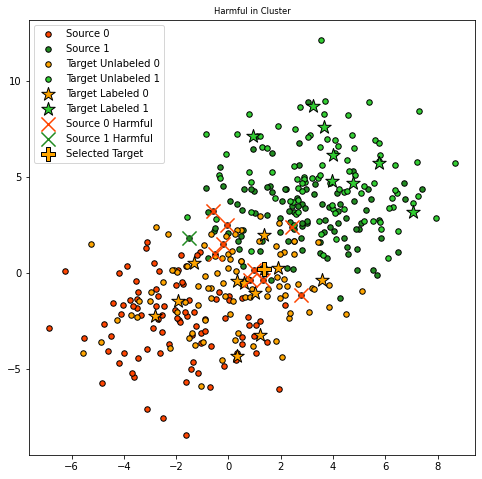

In [9]:
# Plot harmful source for target i

def plot_harmful(filepath, item):
    with open(filepath, "r") as f:
        result = json.load(f)[str(item)]
    
    top_k = 10
    harmful = result["harmful"]
    label = result["label"]

    X_source_harmful = X_source[harmful[:top_k]]
    y_source_harmful = y_source[harmful[:top_k]]

    plt.figure(figsize=(8, 8))
    plt.title("Harmful in Cluster", fontsize="small")

    ss = []
    ss.append(plt.scatter(X_source[y_source==0][:, 0], X_source[y_source==0][:, 1], marker='o', c=colors[0], s=30, edgecolor='k'))
    ss.append(plt.scatter(X_source[y_source==1][:, 0], X_source[y_source==1][:, 1], marker='o', c=colors[1], s=30, edgecolor='k'))
    ss.append(plt.scatter(X_target_unlabeled[y_target_unlabeled==0][:, 0], X_target_unlabeled[y_target_unlabeled==0][:, 1], marker='o', c=colors[2], s=30, edgecolor='k'))
    ss.append(plt.scatter(X_target_unlabeled[y_target_unlabeled==1][:, 0], X_target_unlabeled[y_target_unlabeled==1][:, 1], marker='o', c=colors[3], s=30, edgecolor='k'))
    ss.append(plt.scatter(X_target_labeled[y_target_labeled==0][:, 0], X_target_labeled[y_target_labeled==0][:, 1], marker='*', c=colors[2], s=200, edgecolor='k'))
    ss.append(plt.scatter(X_target_labeled[y_target_labeled==1][:, 0], X_target_labeled[y_target_labeled==1][:, 1], marker='*', c=colors[3], s=200, edgecolor='k'))

    ss.append(plt.scatter(X_source_harmful[y_source_harmful==0][:, 0], X_source_harmful[y_source_harmful==0][:, 1], marker='x', c=colors[0], s=200, edgecolor='k'))
    ss.append(plt.scatter(X_source_harmful[y_source_harmful==1][:, 0], X_source_harmful[y_source_harmful==1][:, 1], marker='x', c=colors[1], s=200, edgecolor='k'))

    ss.append(plt.scatter(X_target_labeled[item, 0], X_target_labeled[item, 1], marker='P', c=colors[2] if label == 0 else colors[3], s=200, edgecolor='k'))

    plt.legend(ss, ("Source 0", "Source 1", "Target Unlabeled 0", "Target Unlabeled 1", "Target Labeled 0", "Target Labeled 1", "Source 0 Harmful", "Source 1 Harmful", "Selected Target"))

    plt.show()

plot_harmful("outdir/influence_results_0_False_2021-07-19-06-42-08.json", 1)

In [37]:
def load_influences(filepath, item=None):
    with open(filepath, "r") as f:
        raw_result = json.load(f)
    
    if item is not None:
        return raw_result[str(item)]

    influences0 = []
    influences1 = []
    for k, v in raw_result.items():
        influences0.append(v["influence"]) if v["label"] == 0 else influences1.append(v["influence"])
        print(f"Top 10 harmful for {k} (label={v['label']}): {v['harmful'][:10]}")
    
    influences0 = np.mean(influences0, axis=0)
    influences1 = np.mean(influences1, axis=0)
    harmful0 = np.argsort(influences0)
    harmful1 = np.argsort(influences1)
    print(f"Top 20 harmful in average for label 0: {harmful0[:20]}")
    print(f"Top 20 harmful in average for label 1: {harmful1[:20]}")
    return influences0, influences1, harmful0, harmful1

# influences0, influences1, harmful0, harmful1 = load_influences("outdir/influence_results_0_False.json")
influences = load_influences("outdir/influence_results_0_False.json", item=1)